In [0]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

In [0]:
def initWeightsToZero(m):
  if type(m) == nn.Linear:
    m.bias.data.fill_(0)
    m.weight.data.fill_(0)

In [0]:
def evaluateNetwork(Net, normalize=False, batchSize=32, zeroWeight=False, learningRate=0.01, outputType="ephocText", momentum_=0.9):

  trans = [
      transforms.ToTensor(), 
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    
  ]
  transform = transforms.Compose(trans if normalize else [trans[0]])
  

  cifar = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
  cifarTestSet = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
  
  split = int(0.8 * len(cifar))
  indexes = list(range(len(cifar)))
  trainIndexes, validationIndexes = indexes[:split], indexes[split:]

  # sampler objects
  trainSampler = SubsetRandomSampler(trainIndexes)
  validationSampler = SubsetRandomSampler(validationIndexes)

  # iterator objects
  trainLoader = DataLoader(cifar, batch_size=batchSize, sampler=trainSampler)
  validationLoader = DataLoader(cifar, batch_size=batchSize, sampler=validationSampler)
  testLoader = DataLoader(cifarTestSet, batch_size=batchSize)

  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  
  # loss function
  lossFunction = nn.CrossEntropyLoss()
  
  network = Net()
  if(zeroWeight):
    network.apply(initWeightsToZero)

  # optimizer
  optimizer = optim.SGD(network.parameters(), lr=learningRate, momentum=momentum_)
  
  start_time = time.time()
  batchNum = 0
  trainBatchLoss, batchNums = [], []
  for epoch in range(5):
    trainLoss, validLoss = [], []

    ### Train
    for data, target in trainLoader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward Propagation
        output = network(data)

        # compute loss
        loss = lossFunction(output, target)

        # back propagation
        loss.backward()

        # update parameters
        optimizer.step()

        trainLoss.append(loss.item())
        
        batchNum += 1
        if((batchNum % 20) == 0 and outputType=="batchPlot"):
          trainBatchLoss.append(np.mean(trainLoss))
          batchNums.append(batchNum)
          trainLoss = []

    ### Validation
    for data, target in validationLoader:

        output = network(data)
        loss = lossFunction(output, target)
        validLoss.append(loss.item())
    
    if(outputType == "ephocText"):  
      print("Epoch:", epoch+1, "|Training Loss: ", np.mean(trainLoss), "|Validation Loss: ", np.mean(validLoss))
    else:
      print("Epoch:", epoch+1, "|Validation Loss: ", np.mean(validLoss))
      

  if(outputType=="batchPlot"):
    plt.plot(batchNums, trainBatchLoss)
    plt.xlabel("Batch Number")
    plt.ylabel("Train Loss")
    plt.show
    
  elapsedTime = time.time() - start_time
  print("Training time:", elapsedTime)
  
  ### Test
  correct = 0
  total = 0
  with torch.no_grad():
      for data, target in testLoader:

          output = network(data)
          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

# 1)

In [0]:
  class Net1(nn.Module):

      def __init__(self):
          super(Net1, self).__init__()

          self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
          self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
          self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

          self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

          self.linear1 = nn.Linear(64 * (4 * 4), 512)
          self.linear2 = nn.Linear(512, 10)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = self.pool(F.relu(self.conv3(x)))

          x = x.view(-1, 1024)  ## reshaping

          x = F.relu(self.linear1(x))
          x = self.linear2(x)
          return x

## Zero Weight Network

In [8]:
evaluateNetwork(Net=Net1, zeroWeight=True)

0it [00:00, ?it/s]

100%|█████████▉| 170434560/170498071 [00:32<00:00, 4670545.55it/s]

Files already downloaded and verified


170500096it [00:50, 4670545.55it/s]                               

Epoch: 1 |Training Loss:  2.3034087516784667 |Validation Loss:  2.30338269300735
Epoch: 2 |Training Loss:  2.303220442199707 |Validation Loss:  2.302892026048118
Epoch: 3 |Training Loss:  2.3034199333190917 |Validation Loss:  2.303008378123323
Epoch: 4 |Training Loss:  2.3033737691879272 |Validation Loss:  2.3028563394333226
Epoch: 5 |Training Loss:  2.3032839889526366 |Validation Loss:  2.303188312548799
Training time: 259.6043703556061
Accuracy of the network on the test images: 10 %


## Network with Random Weights

In [9]:
evaluateNetwork(Net=Net1)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.8007492104530334 |Validation Loss:  1.4265289839845114
Epoch: 2 |Training Loss:  1.3270365458488464 |Validation Loss:  1.2452350757754267
Epoch: 3 |Training Loss:  1.1023916879177094 |Validation Loss:  1.0842122012814774
Epoch: 4 |Training Loss:  0.9363559620857239 |Validation Loss:  1.0184609882366924
Epoch: 5 |Training Loss:  0.8128979505062103 |Validation Loss:  0.9249930377014148
Training time: 252.46883487701416
Accuracy of the network on the test images: 67 %


# 2) Two Layer Network

In [0]:
class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        
        self.pool = nn.MaxPool2d(2, 2) # kernel_size , stride

        self.linear1 = nn.Linear(16 * (14 * 14), 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        
        x = x.view(-1, 16 * (14 * 14))  ## reshaping

        x = self.linear1(x)
        return x

In [11]:
evaluateNetwork(Net=Net2, learningRate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.9456928957939148 |Validation Loss:  1.7481653427544492
Epoch: 2 |Training Loss:  1.634460257911682 |Validation Loss:  1.6082928980501314
Epoch: 3 |Training Loss:  1.4786347235679627 |Validation Loss:  1.4454045404260532
Epoch: 4 |Training Loss:  1.3906743395328522 |Validation Loss:  1.396009013485223
Epoch: 5 |Training Loss:  1.3464128152370454 |Validation Loss:  1.3764929230601644
Training time: 108.65905833244324
Accuracy of the network on the test images: 52 %


# 3) Network with Normalization

In [15]:
evaluateNetwork(Net=Net1, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.6318812184333802 |Validation Loss:  1.265738382507056
Epoch: 2 |Training Loss:  1.1342535645961762 |Validation Loss:  1.0213625400591964
Epoch: 3 |Training Loss:  0.9116428291082382 |Validation Loss:  0.8970799268053743
Epoch: 4 |Training Loss:  0.767465466761589 |Validation Loss:  0.9254541628467389
Epoch: 5 |Training Loss:  0.6541620981574059 |Validation Loss:  0.8615348025823173
Training time: 274.42339992523193
Accuracy of the network on the test images: 70 %


# 4) Effect of Learning Rate on Network

### learning rate = 0.1

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Validation Loss:  1.7008870725814527
Epoch: 2 |Validation Loss:  1.6820313820061974
Epoch: 3 |Validation Loss:  1.7564301814514989
Epoch: 4 |Validation Loss:  1.766878911862358
Epoch: 5 |Validation Loss:  1.7785784684050197
Training time: 262.58147072792053
Accuracy of the network on the test images: 35 %


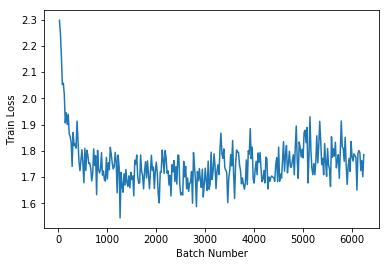

In [28]:
evaluateNetwork(Net=Net1, normalize=True, learningRate=0.07, outputType="batchPlot")

### learning rate = 0.01

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Validation Loss:  1.3052531023756764
Epoch: 2 |Validation Loss:  1.0275526244800313
Epoch: 3 |Validation Loss:  0.9210575520992279
Epoch: 4 |Validation Loss:  0.8568399248603052
Epoch: 5 |Validation Loss:  0.8584645741378156
Training time: 271.0380771160126
Accuracy of the network on the test images: 70 %


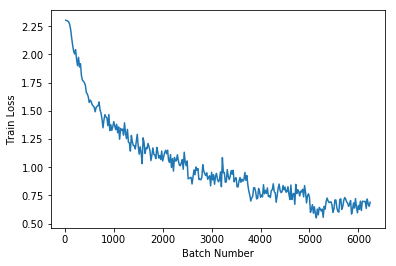

In [21]:
evaluateNetwork(Net=Net1, normalize=True, learningRate=0.01, outputType="batchPlot")

### learning rate = 0.0001

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Validation Loss:  2.2988300582471366
Epoch: 2 |Validation Loss:  2.293507007745127
Epoch: 3 |Validation Loss:  2.2846795370022708
Epoch: 4 |Validation Loss:  2.2658587438991655
Epoch: 5 |Validation Loss:  2.2146633547335006
Training time: 272.2673370838165
Accuracy of the network on the test images: 22 %


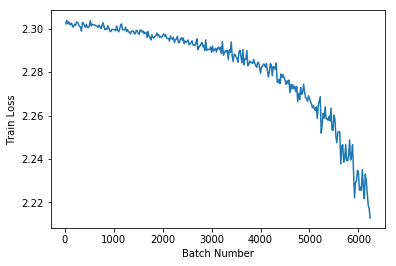

In [22]:
evaluateNetwork(Net=Net1, normalize=True, learningRate=0.0001, outputType="batchPlot")

# 5) Effect of Batch Size on Network

### batch size = 64

In [31]:
evaluateNetwork(Net=Net1, normalize=True, batchSize=64)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.7889031579971313 |Validation Loss:  1.422423954981907
Epoch: 2 |Training Loss:  1.2913023562431336 |Validation Loss:  1.1905038702260158
Epoch: 3 |Training Loss:  1.0531460809707642 |Validation Loss:  1.0341583475185807
Epoch: 4 |Training Loss:  0.9085641683578491 |Validation Loss:  0.9357685572022845
Epoch: 5 |Training Loss:  0.7908004652500152 |Validation Loss:  0.8493366108578482
Training time: 250.8223271369934
Accuracy of the network on the test images: 70 %


In [34]:
evaluateNetwork(Net=Net1, normalize=True, batchSize=64, learningRate=0.05)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.5896427129745483 |Validation Loss:  1.257612699156354
Epoch: 2 |Training Loss:  1.163565060043335 |Validation Loss:  1.1294949309081788
Epoch: 3 |Training Loss:  1.0276961307525634 |Validation Loss:  1.0557689552853822
Epoch: 4 |Training Loss:  0.9302632021427154 |Validation Loss:  1.0688918582193412
Epoch: 5 |Training Loss:  0.8714286916255951 |Validation Loss:  1.171356332529882
Training time: 245.6736147403717
Accuracy of the network on the test images: 61 %


### batch size = 256

In [32]:
evaluateNetwork(Net=Net1, normalize=True, batchSize=256)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  2.191500560493226 |Validation Loss:  1.9633248269557952
Epoch: 2 |Training Loss:  1.7911584028013192 |Validation Loss:  1.6461790055036545
Epoch: 3 |Training Loss:  1.5512089304103973 |Validation Loss:  1.4917387455701827
Epoch: 4 |Training Loss:  1.3945331786088884 |Validation Loss:  1.4139004230499268
Epoch: 5 |Training Loss:  1.275004750604083 |Validation Loss:  1.222489106655121
Training time: 236.6599543094635
Accuracy of the network on the test images: 56 %


In [30]:
evaluateNetwork(Net=Net1, normalize=True, batchSize=256, learningRate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.802912678688195 |Validation Loss:  1.3426841378211976
Epoch: 2 |Training Loss:  1.2493421849171826 |Validation Loss:  1.1454534500837326
Epoch: 3 |Training Loss:  1.0586192262400487 |Validation Loss:  1.0731780290603639
Epoch: 4 |Training Loss:  0.9040429352954694 |Validation Loss:  1.0075796008110047
Epoch: 5 |Training Loss:  0.7724812983707258 |Validation Loss:  0.9266105845570565
Training time: 229.06286644935608
Accuracy of the network on the test images: 68 %


# 6) Different Activation Functions

### tanh

In [0]:
class Net_tanh(nn.Module):

    def __init__(self):
        super(Net_leakyRelu, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.linear1 = nn.Linear(64 * (4 * 4), 512)
        self.linear2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))

        x = x.view(-1, 1024)  ## reshaping

        x = F.leaky_relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [64]:
evaluateNetwork(Net=Net_ackFunc, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.5954821367263794 |Validation Loss:  1.3095929436028575
Epoch: 2 |Training Loss:  1.0940746612548828 |Validation Loss:  1.0159024099191538
Epoch: 3 |Training Loss:  0.8947905774593353 |Validation Loss:  0.9190141938555355
Epoch: 4 |Training Loss:  0.7533263073444366 |Validation Loss:  0.8514402927682042
Epoch: 5 |Training Loss:  0.6467311169266701 |Validation Loss:  0.9040699112720002
Training time: 268.95976734161377
Accuracy of the network on the test images: 69 %


### relu

In [67]:
evaluateNetwork(Net=Net1, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.6489029582500458 |Validation Loss:  1.2885131675976154
Epoch: 2 |Training Loss:  1.141836962556839 |Validation Loss:  1.0233613999126057
Epoch: 3 |Training Loss:  0.9366183966636658 |Validation Loss:  0.942835420465317
Epoch: 4 |Training Loss:  0.7951607717514038 |Validation Loss:  0.8670361360993248
Epoch: 5 |Training Loss:  0.6696334651947021 |Validation Loss:  0.8247657887661419
Training time: 269.4092044830322
Accuracy of the network on the test images: 70 %


### leakyrelu

In [0]:
class Net_leakyRelu(nn.Module):

    def __init__(self):
        super(Net_leakyRelu, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.linear1 = nn.Linear(64 * (4 * 4), 512)
        self.linear2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))

        x = x.view(-1, 1024)  ## reshaping

        x = F.leaky_relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [49]:
evaluateNetwork(Net=Net_leakyRelu, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.6585179952144622 |Validation Loss:  1.3472920557180532
Epoch: 2 |Training Loss:  1.1499838267803193 |Validation Loss:  1.0545802619129705
Epoch: 3 |Training Loss:  0.9314553303241729 |Validation Loss:  0.8723846346425553
Epoch: 4 |Training Loss:  0.7814177124500274 |Validation Loss:  0.9007532088139567
Epoch: 5 |Training Loss:  0.6613423487782478 |Validation Loss:  0.8623798191547394
Training time: 315.2214798927307
Accuracy of the network on the test images: 70 %


### softplus

In [0]:
class Net_softplus(nn.Module):
    
    def __init__(self):
        super(Net_softplus, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.linear1 = nn.Linear(64 * (4 * 4), 512)
        self.linear2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.softplus(self.conv1(x)))
        x = self.pool(F.softplus(self.conv2(x)))
        x = self.pool(F.softplus(self.conv3(x)))

        x = x.view(-1, 1024)  ## reshaping

        x = F.softplus(self.linear1(x))
        x = self.linear2(x)
        return x

In [62]:
evaluateNetwork(Net=Net_softplus, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  2.2085207825660707 |Validation Loss:  1.974759954233139
Epoch: 2 |Training Loss:  1.7062097623825074 |Validation Loss:  1.5492500200058326
Epoch: 3 |Training Loss:  1.4292797028064728 |Validation Loss:  1.389527882821263
Epoch: 4 |Training Loss:  1.2724703412532807 |Validation Loss:  1.2609665940363948
Epoch: 5 |Training Loss:  1.151931735610962 |Validation Loss:  1.1977429740345136
Training time: 730.3430860042572
Accuracy of the network on the test images: 58 %


# 7) Effect of Momentum on SGD

### without momentum

In [66]:
evaluateNetwork(Net=Net1, normalize=True, momentum_=0)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  2.206315065193176 |Validation Loss:  1.9573718187527154
Epoch: 2 |Training Loss:  1.7846874520301819 |Validation Loss:  1.6372513397813986
Epoch: 3 |Training Loss:  1.5707276392936707 |Validation Loss:  1.5043304583515984
Epoch: 4 |Training Loss:  1.434236606168747 |Validation Loss:  1.3782472157249817
Epoch: 5 |Training Loss:  1.327245115852356 |Validation Loss:  1.2810725533543303
Training time: 267.7429630756378
Accuracy of the network on the test images: 53 %


### with momentum

In [68]:
evaluateNetwork(Net=Net1, normalize=True)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 |Training Loss:  1.6441562950611115 |Validation Loss:  1.3787087573410985
Epoch: 2 |Training Loss:  1.1420481600284575 |Validation Loss:  1.033905130605728
Epoch: 3 |Training Loss:  0.915047332572937 |Validation Loss:  0.9433187644321698
Epoch: 4 |Training Loss:  0.7774663432598115 |Validation Loss:  0.8638745463503816
Epoch: 5 |Training Loss:  0.6579337474942207 |Validation Loss:  0.8205470999780173
Training time: 268.9390833377838
Accuracy of the network on the test images: 71 %
